In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
from tqdm import tqdm
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from concorde.tools import get_list, readFort22, from_mag_to_uv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.options.display.max_rows = 10

import warnings
warnings.filterwarnings("ignore")
from matplotlib.offsetbox import AnchoredText

from scipy import signal

In [2]:
pathout = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')

## Preprocess

### Read data

#### Read fort.22 files and compute parameters

In [3]:
## oregon has new coordinates becuase the station gets dry in the base simulation.
## old coordinates are (-75.548, 35.795)
ys = [36.183, 35.795, 35.209, 34.717, 34.227, 34.213]
xs = [-75.745, -75.549, -75.704, -76.67, -77.953, -77.787]
names = ['duck', 'oregon', 'hatteras', 'beaufort', 'wilmington', 'wrightsville']

In [4]:
## files were extracted from HPC, so each fort.22 was the file used to run each individual simulation
pathin = Path(r'/media/tacuevas/Extreme SSD/batch02')
files = sorted(get_list(pathin, ends = 'fort.22'))

SystemExit: The list is empty

In [5]:
def stormDir(df):
    ''' direction going to as currents
    '''
    x = (df.loc[:, 'lon'].shift(1) - df.loc[:, 'lon']).values
    y = (df.loc[:, 'lat'].shift(1) - df.loc[:, 'lat']).values
    d = np.arctan2(x, y)
    d2 = np.rad2deg(d)
    d2 = np.mod(d2, 360)

    return d2

def forwardSpeed(df):
    '''
    '''
    vellist = [np.nan] 
    for i, j in zip(df.index[:-1], df.index[1:]):
        p1 = (df.loc[i, 'lat'], df.loc[i, 'lon'])
        p2 = (df.loc[j, 'lat'], df.loc[j, 'lon'])
        dist = geopy.distance.geodesic(p2, p1).km
        vel = dist/3 ##km/hr, time step is 3hr
        vellist.append(vel)
    
    return vellist

def dist2NC(y, x, pnt):
    return geopy.distance.geodesic(pnt, (y, x)).km

In [6]:
## Read individual files and compute extra parameters
dct = {}
for f in tqdm(files):
    
    run = os.path.dirname(f).split('/')[-1]

    f22 = readFort22(f)
    f22['heading_dir'] = stormDir(f22)
    f22['forward_speed'] = forwardSpeed(f22)

    for ntg, xtg, ytg in zip(names, xs, ys):
        d = [dist2NC(ytg, xtg, (y, x)) for x, y in zip(f22['lon'], f22['lat'])]
        f22[f'dist_to_{ntg}'] = d
    
    index_aux = f22[f22['forward_speed'] > 0].index
    track_start = f22.index.to_list().index(index_aux[0]) 
    f22final = f22.iloc[track_start - 1:, :]
    ## forward fill first time step of heading_dir and forward_speed to avoid 0s
    f22final.iloc[0, 5] = f22final.iloc[1, 5]
    f22final.iloc[0, 6] = f22final.iloc[1, 6]
    u, v = from_mag_to_uv(f22final['forward_speed'], f22final['heading_dir'], meteo = False)
    f22final['forward_speed_u'] = u
    f22final['forward_speed_v'] = v

    dct[run] = f22final

with open(pathout/'dct_tracksAll_batch02.pkl', 'wb') as fout:
    pickle.dump(dct, fout)

100%|██████████| 1813/1813 [03:45<00:00,  8.03it/s]


In [8]:
## get length of each fort.22
lengths = []
for k in sorted(dct.keys()):
    l = len(dct[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.head()

,length,run
0,48,0000
1,46,0001
2,191,0002
3,39,0003
4,66,0004


##### Compare fort.22 and data from STORM

In [5]:
dct = pd.read_pickle(pathout/'dct_tracksAll_batch02.pkl')

In [28]:
dfIn[dfIn['tc_number'] == 61112.0]

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,...,tc_number,headingDir,forwardSpeed,dist_to_NC0,dist_to_NC1,dist_to_NC2,dist_to_NC3,windIntersectNC,runIndex,randomDate
1951356,5592.0,8.0,12.0,37.0,1.0,29.7,-68.5,969.6,39.600000,22.223999,...,61112,0.000000,7.389715,1012.383405,935.591725,932.006150,1021.987838,0,15,2001-07-19 06:00:00
1951357,5592.0,8.0,12.0,38.0,1.0,30.0,-68.5,968.4,40.300000,22.223999,...,61112,333.434949,11.084992,996.261209,915.303465,908.966004,996.939456,0,15,2001-07-19 09:00:00
1951358,5592.0,8.0,12.0,39.0,1.0,30.2,-68.6,967.4,40.900000,22.223999,...,61112,341.565051,8.058498,977.417197,894.393527,886.833679,974.012835,0,15,2001-07-19 12:00:00
1951359,5592.0,8.0,12.0,40.0,1.0,30.5,-68.7,967.7,40.700000,22.223999,...,61112,26.565051,11.539795,953.982109,867.347700,857.491916,943.057425,0,15,2001-07-19 15:00:00
1951360,5592.0,8.0,12.0,41.0,1.0,30.9,-68.5,968.7,40.100000,22.223999,...,61112,18.434949,16.102660,953.186652,859.261272,843.909647,924.871078,0,15,2001-07-19 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951408,5592.0,8.0,12.0,89.0,1.0,33.8,-78.7,965.6,40.546718,22.223999,...,61112,71.565051,6.173381,65.725368,225.898081,319.770442,393.434116,1,15,2001-07-25 18:00:00
1951409,5592.0,8.0,12.0,90.0,1.0,33.9,-78.4,935.0,57.747037,22.223999,...,61112,71.565051,9.965906,36.997138,196.130519,290.674491,367.440129,1,15,2001-07-25 21:00:00
1951410,5592.0,8.0,12.0,91.0,1.0,34.0,-78.1,883.4,83.502870,22.223999,...,61112,71.565051,9.955902,14.439015,166.427892,261.761627,342.054461,1,15,2001-07-26 00:00:00
1951411,5592.0,8.0,12.0,92.0,1.0,34.1,-77.8,962.2,42.534127,30.249332,...,61112,71.565051,9.945874,28.871232,136.813341,233.088883,317.414965,1,15,2001-07-26 03:00:00


<Axes: xlabel='forwardSpeed', ylabel='Density'>

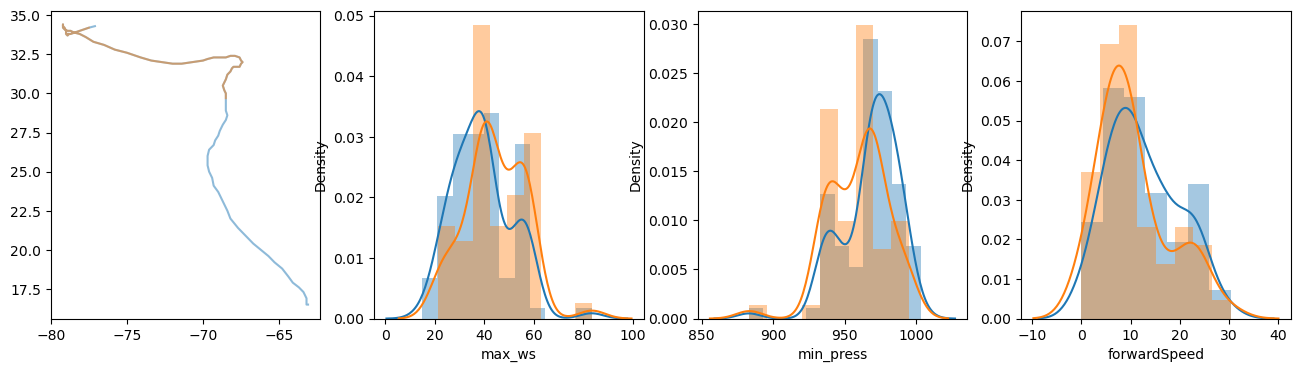

In [32]:
## read tracks from STORM files
## first set of runs of 01 considers the full track
pathStorm = Path(r'../data/STORM/processed/batch02')
dfIn = pd.read_pickle(pathStorm/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

key = '0015'
dfInSub = dfIn[dfIn['runIndex'] == int(key)]
fig, ax = plt.subplots(figsize = (16, 4), ncols = 4)
ax[0].plot(dct[key]['lon'], dct[key]['lat'], alpha = 0.5)
ax[0].plot(dfInSub['lon'], dfInSub['lat'], alpha = 0.5)
sns.distplot(dct[key]['wind_speed'], ax = ax[1])
sns.distplot(dfInSub['max_ws'], ax = ax[1])
sns.distplot(dct[key]['pressure'], ax = ax[2])
sns.distplot(dfInSub['min_press'], ax = ax[2])
sns.distplot(dct[key]['forward_speed'], ax = ax[3])
sns.distplot(dfInSub['forwardSpeed'], ax = ax[3])

In [10]:
durs = []
for tc in dfIn['runIndex'].unique():
    subdf = dfIn[dfIn['runIndex'] == tc]
    durs.append(len(subdf)*3)
dfdurs = pd.DataFrame({'duration': durs}, index = dfIn['runIndex'].unique())

In [22]:
dfdurs.sum()*3

duration    554760
dtype: int64

In [24]:
(1 - 554760/883395)*100

37.20136518771331

In [18]:
dfdurs.describe()

,duration
count,1814.000000
mean,101.940463
std,28.302495
min,30.000000
25%,81.000000
50%,111.000000
75%,120.000000
max,237.000000


In [19]:
30.000000/24

1.25

In [20]:
237.000000/24

9.875

#### Read tides from base simulation

In [6]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing')
baseNOAA = pd.read_csv(pathin/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)
baseNOAA.head()

,Duck,Oregon,Hatteras,Beaufort,Wilmington,Wrightsville,Boundary
2001-06-16 00:10:00,-1.485873e-09,-5.945474e-09,2.384953e-08,-5.303312e-09,-1.335170e-08,-5.331151e-08,6.041282e-08
2001-06-16 00:20:00,2.320222e-08,-3.422621e-08,9.140826e-08,-6.140789e-08,-6.228204e-08,-2.218648e-07,1.925880e-08
2001-06-16 00:30:00,1.279047e-07,-8.250435e-08,1.656895e-07,-2.530292e-07,-1.736809e-07,-5.033769e-07,2.066350e-05
2001-06-16 00:40:00,3.680322e-07,-1.370996e-07,2.378175e-07,-6.488393e-07,-3.553525e-07,-8.826800e-07,1.101777e-04
2001-06-16 00:50:00,8.014003e-07,-1.818608e-07,2.992687e-07,-1.241783e-06,-6.162476e-07,-1.344859e-06,2.169322e-04


<AxesSubplot: >

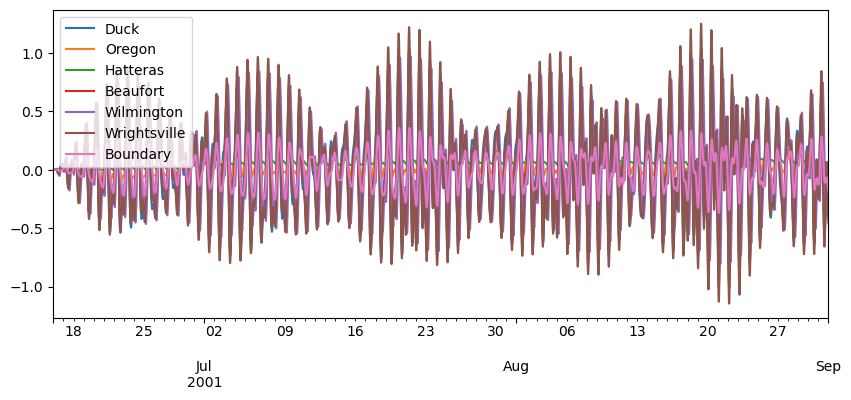

In [4]:
baseNOAA.plot(figsize = (10, 4))

#### Reduce length of the tracks ran in first iteration of batch 02

In [7]:
## get length of each fort.22
pathStorm = Path(r'../data/STORM/processed/batch02')
dfIn = pd.read_pickle(pathStorm/'STORM_NA_R5_In_sortedMDA_shortened_dates_v3.pkl')

lengths_tracks = []
for k in sorted(dfIn['runIndex'].unique()):
    l = len(dfIn[dfIn['runIndex'] == k])
    lengths_tracks.append(l)
dflStorm = pd.DataFrame({'length': lengths_tracks, 'run': dfIn['runIndex'].unique()})
dflStorm.head()

,length,run
0,39,0
1,46,1
2,48,2
3,27,3
4,24,4


In [8]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing')
p01batch2 = pd.read_csv(pathin/'runs01_batch02.txt', header=None)
p01batch2['run'] = [x[:4] for x in p01batch2.iloc[:, 0]]
p01batch2.head()

,0,run
0,0000.tar.gz,0000
1,0002.tar.gz,0002
2,0003.tar.gz,0003
3,0004.tar.gz,0004
4,0007.tar.gz,0007


In [9]:
dct = pd.read_pickle(pathout/'dct_tracksAll_batch02.pkl')

In [10]:
dctTracks = {}
distsAll = []
c1 = 0
c2 = 0
dummy = []
for ik, k in enumerate(dct.keys()):
    if k in p01batch2['run'].to_list():
        dfF22 = dct[k]
        dfStorm = dfIn[dfIn['runIndex'] == int(k)]
        difLen = len(dfF22) - len(dfStorm)
        if difLen > 0:
            c1 += 1
            dists = []
            for i in range(difLen):
                dfF22s = dfF22.iloc[i:len(dfStorm) + i]
                dist = np.sqrt((dfF22s['lon'].values - dfStorm['lon'].values)**2 + 
                                                (dfF22s['lat'].values - dfStorm['lat'].values)**2)
                dists.append(np.max(dist))

            j = np.argmin(dists)
            dfF22s = dfF22.iloc[j:len(dfStorm)+j]
            dctTracks[k] = dfF22s

            dist = np.sqrt((dfF22s['lon'].values - dfStorm['lon'].values)**2 + 
                                (dfF22s['lat'].values - dfStorm['lat'].values)**2)
            distsAll.append(dist)
            dummy.append(k)

        else:
            c2 += 1
            dctTracks[k] = dct[k]
    else:
        dctTracks[k] = dct[k]

with open(pathout/'dct_tracksAll_batch02_lengthCorr.pkl', 'wb') as fout:
    pickle.dump(dct, fout)

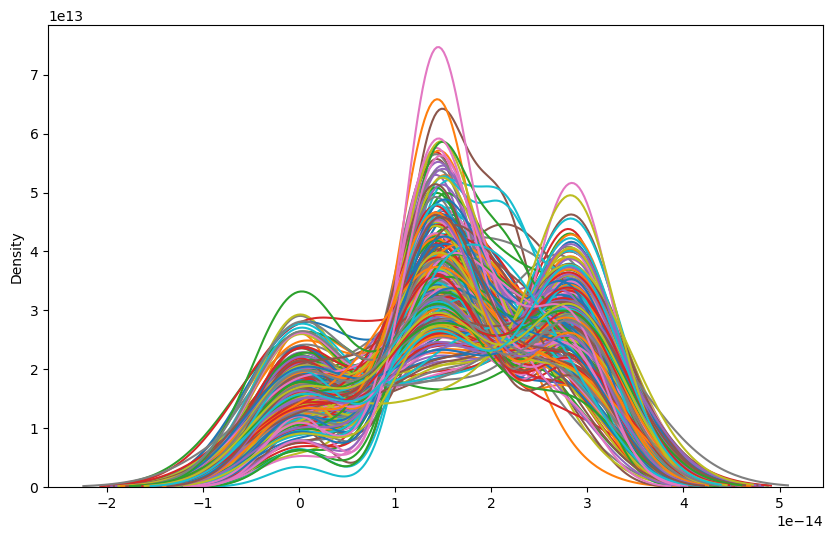

In [11]:
fig, ax = plt.subplots(figsize = (10, 6))
maxs = []
for k in distsAll:
    # maxs.append(np.max(k))
    sns.distplot(k, ax = ax, hist=False)

1400


<AxesSubplot: xlabel='forwardSpeed', ylabel='Density'>

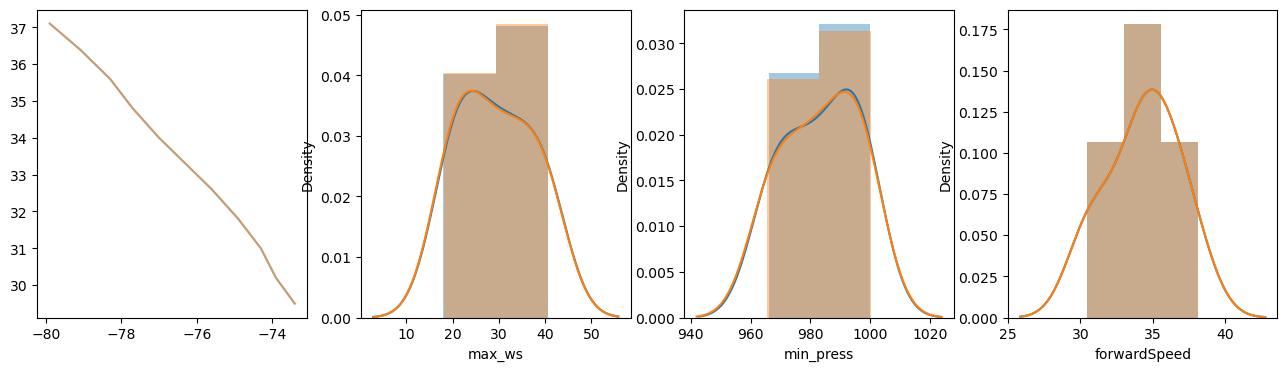

In [13]:
key = f'{np.random.randint(len(dctTracks.keys())):04d}'
# key = '0178'
print(key)
dfInSub = dfIn[dfIn['runIndex'] == int(key)]
fig, ax = plt.subplots(figsize = (16, 4), ncols = 4)
ax[0].plot(dctTracks[key]['lon'], dctTracks[key]['lat'], alpha = 0.5)
ax[0].plot(dfInSub['lon'], dfInSub['lat'], alpha = 0.5)
sns.distplot(dctTracks[key]['wind_speed'], ax = ax[1])
sns.distplot(dfInSub['max_ws'], ax = ax[1])
sns.distplot(dctTracks[key]['pressure'], ax = ax[2])
sns.distplot(dfInSub['min_press'], ax = ax[2])
sns.distplot(dctTracks[key]['forward_speed'], ax = ax[3])
sns.distplot(dfInSub['forwardSpeed'], ax = ax[3])

In [12]:
## get length of each fort.22
lengths = []
for k in sorted(dctTracks.keys()):
    l = len(dctTracks[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1813.0,33.974628,9.435585,10.0,27.0,37.0,40.0,79.0


### Merge track and tides

In [13]:
maxLength = dfl['length'].max()
print(maxLength)

79


In [14]:
dctInputRes = {}
for ik, k in enumerate(dctTracks.keys()):
    dfTrack = dctTracks[k]
    ## subset tide only base simulation
    dfTides = baseNOAA.loc[dfTrack.index[0]:dfTrack.index[-1], :]
    ## resample
    dfTrack_res = dfTrack.resample('1H').interpolate(method = 'linear')
    dfTides_res = dfTides.resample('1H').mean()
    ## fft of track data
    Xfft = np.abs(np.fft.fft(dfTrack_res.values, axis = 1))
    dfFFT = pd.DataFrame(index = dfTides_res.index, columns = [f'{col}_fft' for col in dfTrack_res.columns],
                         data = Xfft)

    dfInput = pd.concat([dfTrack_res, dfTides_res, dfFFT], axis = 1)
    dctInputRes[k] = dfInput

    if ik == 0:
        dfInput.to_csv(pathout/'dct_tracksAll_batch02_lengthCorr_tides_resampled_SAMPLE.csv')

with open(pathout/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl', 'wb') as fout:
    pickle.dump(dctInputRes, fout)

In [22]:
## get length of each fort.22
lengths = []
for k in sorted(dctInputRes.keys()):
    l = len(dctInputRes[k])
    lengths.append(l)
dfl = pd.DataFrame({'length': lengths, 'run': dct.keys()})
dfl.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1813.0,99.923883,28.306754,28.0,79.0,109.0,118.0,235.0


### Zero Padding

In [23]:
inpArrPadded = []
for k in dctInputRes.keys():
    aux = dctInputRes[k]
    padLength = dfl['length'].max() - len(aux)
    auxPadded = np.pad(aux.values, ((padLength, 0), (0, 0)), mode = 'constant')
    inpArrPadded.append(auxPadded)
inpArrPadded = np.asarray(inpArrPadded, dtype = float)

np.save(pathout/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy', inpArrPadded, allow_pickle=False)

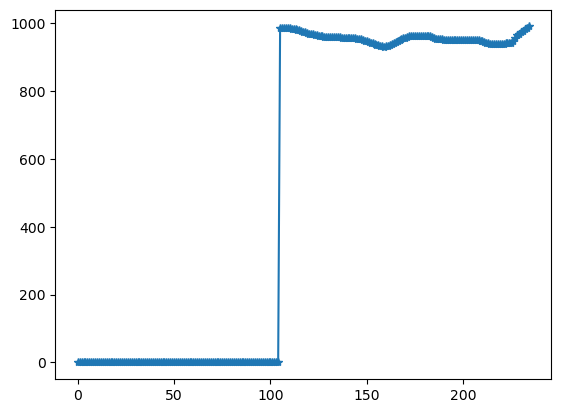

In [24]:
plt.plot(inpArrPadded[100, :, 3], marker = '*')

## Test train split

### Sort by dissimilarity

In [25]:
pathInputs = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')

In [26]:
## read inputs
pathInputs = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
inpArrPadded = np.load(pathInputs/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## read outputs
dfout = pd.read_csv(pathInputs.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))
print(arrOut.shape)

testPer = 0.15
testNumber = int(np.ceil(testPer*arrOut.shape[0])) 
print(f'Number of storms for testing {testNumber}')

(1813, 6, 1)
Number of storms for testing 272


In [27]:
X_train  = inpArrPadded[:arrOut.shape[0] - testNumber, :, :]
Y_train  = arrOut[:arrOut.shape[0] - testNumber, :, :]

X_test  = inpArrPadded[-testNumber:, :, :]
Y_test  = arrOut[-testNumber:, :, :]

print(f'X train shape: {X_train.shape}')
print(f'y train shape: {Y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {Y_test.shape}')

X train shape: (1541, 235, 37)
y train shape: (1541, 6, 1)
X test shape: (272, 235, 37)
y test shape: (272, 6, 1)


#### Non scaled

In [28]:
pathoutNN = Path(r'../models/NNmodel/inputs/dissIndex_last15perForTesting/_revR1')
np.save(pathoutNN/'X_train_nonScaled_allInputs.npy', X_train, allow_pickle = False)
np.save(pathoutNN/'y_train.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/'X_test_nonScaled_allInputs.npy', X_test, allow_pickle = False)
np.save(pathoutNN/'y_test.npy', Y_test, allow_pickle = False)

#### Scaled data

In [30]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.fit_transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)

np.save(pathoutNN/'X_train_standarScaled_allInputs.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/'X_test_standarScaled_allInputs.npy', X_test_sc, allow_pickle = False)
with open(pathoutNN/'standarScaler_allInputs.pkl', 'wb') as file:
    pickle.dump(scaler, file)

(1541, 235, 37)
(272, 235, 37)


### Random split

In [31]:
## read inputs
pathInputs = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
inpArrPadded = np.load(pathInputs/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')
print(inpArrPadded.shape)

## read outputs
dfout = pd.read_csv(pathInputs.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))
print(arrOut.shape)

(1813, 235, 37)
(1813, 6, 1)


In [32]:
pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test = train_test_split(inpArrPadded, arrOut, test_size=0.15, random_state=42)

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.fit_transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/'X_train_standarScaled_allInputs.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/'y_train.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/'X_test_standarScaled_allInputs.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/'y_test.npy', Y_test, allow_pickle = False)

with open(pathoutNN/'standarScaler_allInputs.pkl', 'wb') as file:
    pickle.dump(scaler, file)

(1541, 235, 37)
(1541, 6, 1)
(272, 235, 37)
(272, 6, 1)


In [33]:
np.save(pathoutNN/'X_train_nonScaled_allInputs.npy', X_train, allow_pickle = False)
np.save(pathoutNN/'X_test_nonScaled_allInputs.npy', X_test, allow_pickle = False)

## Augment data

In [3]:
np.random.seed(42)

### Augment all storms

In [4]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NOAA_NC_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))

In [4]:
dummydummy = baseNOAA.describe().T
for i in dummydummy.index:
    ma = dummydummy.loc[i, 'max']
    mi = dummydummy.loc[i, 'min']
    print(f'Tidal range {i} = {ma - mi:0.2f}')

Tidal range Duck = 1.93
Tidal range Oregon = 0.53
Tidal range Hatteras = 0.21
Tidal range Beaufort = 2.05
Tidal range Wilmington = 1.78
Tidal range Wrightsville = 2.40
Tidal range Boundary = 0.73


In [5]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 50
for ik, k in tqdm(enumerate(dctTracks.keys())):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        ## change dates
        newTide.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide.iloc[:, :-1] + dfSurgeOnly).loc[track.index[0]:, :]
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)

        ## define zero padded input array as dataframe to replace new tide values
        inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
        inpArrCp2 = inpArrCp.copy()
        ## change values
        inpArrCp2.iloc[-len(track):, 15:22] = newTide.loc[newTide.index.isin(track.index), :].values
        augmented_inputs.append(inpArrCp2.values)

        augmented_outputs.append(maxNewWL.values.reshape((maxNewWL.shape[0], 1)))

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.fit_transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/f'X_train_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_augmentedAllX{nrep_per_storm:02d}.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_augmentedAllX{nrep_per_storm:02d}.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_augmentedAllX{nrep_per_storm:02d}.npy', idx_test, fmt='%d')

with open(pathoutNN/f'standarScaler_augmentedAllX{nrep_per_storm:02d}.pkl', 'wb') as file:
    pickle.dump(scaler, file)

1813it [04:47,  6.32it/s]


(78593, 235, 37)
(78593, 6, 1)
(13870, 235, 37)
(13870, 6, 1)


In [5]:
## just for ploting

aux1, aux2, aux3, aux4 = [], [], [], []
nrep_per_storm = 2
for ik, k in tqdm(enumerate(dctTracks.keys())):
    track = dctTracks[k]
    dfWL = dctWL[k].loc[track.index[0]:, :]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        print(newTide.head())
        aux1.append(newTide)
        ## change dates
        newTide2 = newTide.copy()
        newTide2.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide2.iloc[:, :-1] + dfSurgeOnly)#.loc[track.index[0]:, :]
        aux2.append(newWL)
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)
        aux3.append(maxNewWL)
        aux4.append(newWL.idxmax())
    break

0it [00:00, ?it/s]

                         Duck    Oregon  Hatteras  Beaufort  Wilmington  \
2001-08-05 11:00:00  0.322117  0.235970  0.128260  0.421801    0.825441   
2001-08-05 12:00:00  0.168312  0.176851  0.118531  0.285158    0.795972   
2001-08-05 13:00:00 -0.078998  0.082321  0.093007  0.037345    0.683547   
2001-08-05 14:00:00 -0.266155  0.040902  0.086303 -0.197766    0.533642   
2001-08-05 15:00:00 -0.363591  0.014847  0.079674 -0.302882    0.357087   

                     Wrightsville  Boundary  
2001-08-05 11:00:00      0.340948  0.215783  
2001-08-05 12:00:00      0.163358  0.184378  
2001-08-05 13:00:00     -0.108296  0.129274  
2001-08-05 14:00:00     -0.305944  0.081113  
2001-08-05 15:00:00     -0.399893  0.046018  
                         Duck    Oregon  Hatteras  Beaufort  Wilmington  \
2001-06-21 23:00:00 -0.119349 -0.035693 -0.007755 -0.254588   -0.187655   
2001-06-22 00:00:00 -0.086089 -0.030714 -0.009930 -0.224758   -0.234696   
2001-06-22 01:00:00 -0.010013 -0.009625 -0.00816

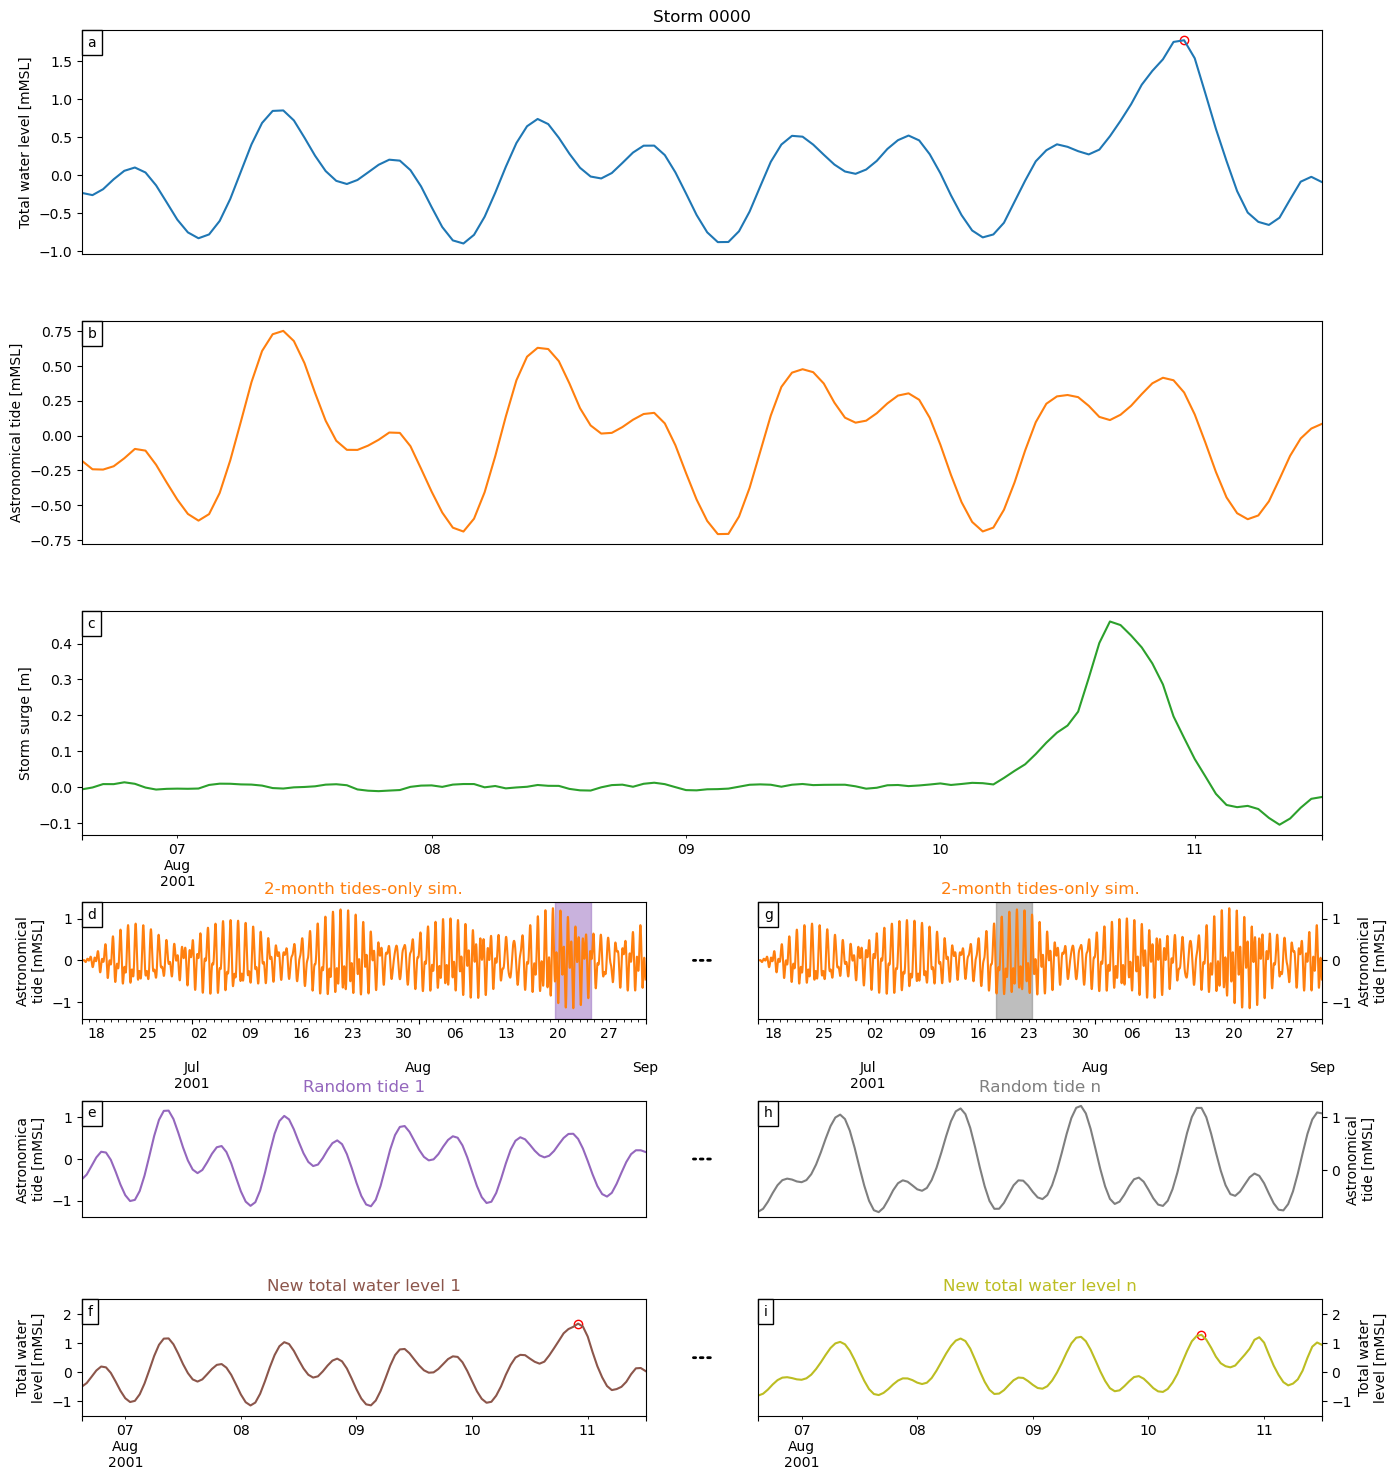

In [39]:
fig = plt.figure(figsize=(16, 18))
outer_grid = fig.add_gridspec(5, 1, hspace=0.3)
ax0 = fig.add_subplot(outer_grid[0, 0])
ax1 = fig.add_subplot(outer_grid[1, 0])
ax2 = fig.add_subplot(outer_grid[2, 0])

dfWL['Wrightsville'].plot(ax = ax0)
ax0.scatter([dfWL['Wrightsville'].idxmax()], [dfWL['Wrightsville'].max()], edgecolor = 'r', facecolor = 'w')
ax0.set_ylabel('Total water level [mMSL]')
ax0.set_title('Storm 0000')

dftide['Duck'].plot(ax = ax1, color = ccolors[1])
ax1.set_ylabel('Astronomical tide [mMSL]')

dfSurgeOnly['Duck'].plot(ax = ax2, color = ccolors[2])
ax2.set_ylabel('Storm surge [m]')
ax0.axes.get_xaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax0.add_artist(AnchoredText('a', loc=2,borderpad=0.,frameon=True, alpha = 0))
ax1.add_artist(AnchoredText('b', loc=2,borderpad=0.,frameon=True, alpha = 0))
ax2.add_artist(AnchoredText('c', loc=2,borderpad=0.,frameon=True, alpha = 0))

inner_grid = outer_grid[3:].subgridspec(3, 2, height_ratios=[1, 1, 1], hspace = 0.7)
ax30 = fig.add_subplot(inner_grid[0, 0])
ax31 = fig.add_subplot(inner_grid[0, 1])
ax40 = fig.add_subplot(inner_grid[1, 0])
ax41 = fig.add_subplot(inner_grid[1, 1])
ax50 = fig.add_subplot(inner_grid[2, 0])
ax51 = fig.add_subplot(inner_grid[2, 1])

baseNOAA['Wrightsville'].plot(ax = ax30, color = ccolors[1])
baseNOAA['Wrightsville'].plot(ax = ax31, color = ccolors[1])

ax30.set_title('2-month tides-only sim.', color = ccolors[1])
ax30.fill_between(x = pd.date_range(aux1[0].index[0], aux1[0].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[4], alpha = 0.5)
ax30.set_ylim([-1.4, 1.4])
ax30.set_ylabel('Astronomical\ntide [mMSL]')
ax30.set_ylim([-1.4, 1.4])
ax30.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
ax30.add_artist(AnchoredText('d', loc=2,borderpad=0.,frameon=True, alpha = 1))

ax40.set_title('Random tide 1', color = ccolors[4])
aux1[0]['Wrightsville'].plot(ax = ax40, color = ccolors[4])
ax40.set_ylabel('Astronomica\ntide [mMSL]')
ax40.set_ylim([-1.4, 1.4])
ax40.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
ax40.add_artist(AnchoredText('e', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax40.axes.get_xaxis().set_visible(False)

ax50.set_title('New total water level 1', color = ccolors[5])
aux2[0]['Wrightsville'].plot(ax = ax50, color = ccolors[5])
ax50.set_ylabel('Total water\nlevel [mMSL]')
ax50.set_ylim([-1.5, 2.5])
ax50.scatter(aux4[0]['Wrightsville'], aux3[0]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
ax50.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
ax50.add_artist(AnchoredText('f', loc=2,borderpad=0.,frameon=True, alpha = 1))

ax31.set_title('2-month tides-only sim.', color = ccolors[1])
ax31.fill_between(x = pd.date_range(aux1[1].index[0], aux1[1].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[7], alpha = 0.5)
ax31.set_ylim([-1.4, 1.4])
ax31.set_ylabel('Astronomical\ntide [mMSL]')
ax31.set_ylim([-1.4, 1.4])
ax31.yaxis.tick_right()
ax31.yaxis.set_label_position("right")
ax31.add_artist(AnchoredText('g', loc=2,borderpad=0.,frameon=True, alpha = 1))

ax41.set_title('Random tide n', color = ccolors[7])
aux1[1]['Wrightsville'].plot(ax = ax41, color = ccolors[7])
ax41.set_ylabel('Astronomical\ntide [mMSL]')
ax40.set_ylim([-1.4, 1.4])
ax41.yaxis.tick_right()
ax41.yaxis.set_label_position("right")
ax41.add_artist(AnchoredText('h', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax41.axes.get_xaxis().set_visible(False)

ax51.set_title('New total water level n', color = ccolors[8])
aux2[1]['Wrightsville'].plot(ax = ax51, color = ccolors[8])
ax51.set_ylabel('Total water\nlevel [mMSL]')
ax51.set_ylim([-1.5, 2.5])
ax51.scatter(aux4[1]['Wrightsville'], aux3[1]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
ax51.yaxis.tick_right()
ax51.yaxis.set_label_position("right")
ax51.add_artist(AnchoredText('i', loc=2,borderpad=0.,frameon=True, alpha = 0))
fig.savefig(r'../documents/thesis/augmentation_procedure.png', dpi = 300, bbox_inches = 'tight')

In [8]:
with plt.rc_context({'font.size': 16}):

    fig = plt.figure(figsize=(16, 20))
    outer_grid = fig.add_gridspec(5, 1, hspace=0.4)
    ax0 = fig.add_subplot(outer_grid[0, 0])
    ax1 = fig.add_subplot(outer_grid[1, 0])
    ax2 = fig.add_subplot(outer_grid[2, 0])

    dfWL['Wrightsville'].plot(ax = ax0)
    ax0.scatter([dfWL['Wrightsville'].idxmax()], [dfWL['Wrightsville'].max()], edgecolor = 'r', facecolor = 'w')
    ax0.set_ylabel('Total water level\n[mMSL]')
    ax0.set_title('Storm 0000')

    dftide['Duck'].plot(ax = ax1, color = ccolors[1])
    ax1.set_ylabel('Astronomical tide\n[mMSL]')

    dfSurgeOnly['Duck'].plot(ax = ax2, color = ccolors[2])
    ax2.set_ylabel('Storm surge [m]')
    ax0.axes.get_xaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax0.add_artist(AnchoredText('a', loc=2,borderpad=0.,frameon=True, alpha = 0))
    ax1.add_artist(AnchoredText('b', loc=2,borderpad=0.,frameon=True, alpha = 0))
    ax2.add_artist(AnchoredText('c', loc=2,borderpad=0.,frameon=True, alpha = 0))

    inner_grid = outer_grid[3:].subgridspec(3, 2, height_ratios=[1, 1, 1], hspace = 1)
    ax30 = fig.add_subplot(inner_grid[0, 0])
    ax31 = fig.add_subplot(inner_grid[0, 1])
    ax40 = fig.add_subplot(inner_grid[1, 0])
    ax41 = fig.add_subplot(inner_grid[1, 1])
    ax50 = fig.add_subplot(inner_grid[2, 0])
    ax51 = fig.add_subplot(inner_grid[2, 1])

    baseNOAA['Wrightsville'].plot(ax = ax30, color = ccolors[1])
    baseNOAA['Wrightsville'].plot(ax = ax31, color = ccolors[1])

    ax30.set_title('2-month tides-only sim.', color = ccolors[1])
    ax30.fill_between(x = pd.date_range(aux1[0].index[0], aux1[0].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[4], alpha = 0.5)
    ax30.set_ylim([-1.4, 1.4])
    ax30.set_ylabel('Astronomical\ntide [mMSL]')
    ax30.set_ylim([-1.4, 1.4])
    ax30.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax30.add_artist(AnchoredText('d', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax40.set_title('Random tide 1', color = ccolors[4])
    aux1[0]['Wrightsville'].plot(ax = ax40, color = ccolors[4])
    ax40.set_ylabel('Astronomica\ntide [mMSL]')
    ax40.set_ylim([-1.4, 1.4])
    ax40.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax40.add_artist(AnchoredText('e', loc=2,borderpad=0.,frameon=True, alpha = 1))
    ax40.axes.get_xaxis().set_visible(False)

    ax50.set_title('New total water level 1', color = ccolors[5])
    aux2[0]['Wrightsville'].plot(ax = ax50, color = ccolors[5])
    ax50.set_ylabel('Total water\nlevel [mMSL]')
    ax50.set_ylim([-1.5, 2.5])
    ax50.scatter(aux4[0]['Wrightsville'], aux3[0]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
    ax50.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax50.add_artist(AnchoredText('f', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax31.set_title('2-month tides-only sim.', color = ccolors[1])
    ax31.fill_between(x = pd.date_range(aux1[1].index[0], aux1[1].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[7], alpha = 0.5)
    ax31.set_ylim([-1.4, 1.4])
    ax31.set_ylabel('Astronomical\ntide [mMSL]')
    ax31.set_ylim([-1.4, 1.4])
    ax31.yaxis.tick_right()
    ax31.yaxis.set_label_position("right")
    ax31.add_artist(AnchoredText('g', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax41.set_title('Random tide n', color = ccolors[7])
    aux1[1]['Wrightsville'].plot(ax = ax41, color = ccolors[7])
    ax41.set_ylabel('Astronomical\ntide [mMSL]')
    ax40.set_ylim([-1.4, 1.4])
    ax41.yaxis.tick_right()
    ax41.yaxis.set_label_position("right")
    ax41.add_artist(AnchoredText('h', loc=2,borderpad=0.,frameon=True, alpha = 1))
    ax41.axes.get_xaxis().set_visible(False)

    ax51.set_title('New total water level n', color = ccolors[8])
    aux2[1]['Wrightsville'].plot(ax = ax51, color = ccolors[8])
    ax51.set_ylabel('Total water\nlevel [mMSL]')
    ax51.set_ylim([-1.5, 2.5])
    ax51.scatter(aux4[1]['Wrightsville'], aux3[1]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
    ax51.yaxis.tick_right()
    ax51.yaxis.set_label_position("right")
    ax51.add_artist(AnchoredText('i', loc=2,borderpad=0.,frameon=True, alpha = 0))
    fig.savefig(r'../documents/defense/augmentation_procedure.png', dpi = 300, bbox_inches = 'tight')

In [22]:
with plt.rc_context({'font.size': 16}):
    fig, ax = plt.subplots(figsize=(16, 20), nrows = 5)
    dfWL['Wrightsville'].plot(ax = ax[0])
    # ax[0].scatter([dfWL['Wrightsville'].idxmax()], [dfWL['Wrightsville'].max()], edgecolor = 'r', facecolor = 'w')
    # ax[0].set_ylabel('Total water level\n[mMSL]')
    ax[0].set_title('Total water level', color = ccolors[0])
    dftide['Wrightsville'].plot(ax = ax[1], color = ccolors[1])
    ax[1].set_title('Astronomical tide', color = ccolors[1])
    # ax[1].set_ylabel('Astronomical tide\n[mMSL]')
    dfSurgeOnly['Wrightsville'].plot(ax = ax[2], color = ccolors[2])
    ax[2].set_title('Storm surge', color = ccolors[2])
    aux1[0]['Wrightsville'].plot(ax = ax[3], color = ccolors[3])
    ax[3].set_title('Random astronomical tide # 1', color = ccolors[3])
    aux2[0]['Wrightsville'].plot(ax = ax[4], color = ccolors[4])
    ax[4].set_title('New total water level # 1', color = ccolors[4])
    
    ax[0].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[2].axes.get_xaxis().set_visible(False)
    ax[3].axes.get_xaxis().set_visible(False)
    ax[4].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)
    ax[2].axes.get_yaxis().set_visible(False)
    ax[3].axes.get_yaxis().set_visible(False)
    ax[4].axes.get_yaxis().set_visible(False)

    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['top'].set_visible(False)
    ax[4].spines['right'].set_visible(False)
    ax[4].spines['top'].set_visible(False)

    fig.savefig(r'../documents/defense/augmentation_procedure2.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
with plt.rc_context({'font.size': 16}):

    fig = plt.figure(figsize=(16, 20))
    outer_grid = fig.add_gridspec(5, 1, hspace=0.4)
    ax0 = fig.add_subplot(outer_grid[0, 0])
    ax1 = fig.add_subplot(outer_grid[1, 0])
    ax2 = fig.add_subplot(outer_grid[2, 0])

    dfWL['Wrightsville'].plot(ax = ax0)
    ax0.scatter([dfWL['Wrightsville'].idxmax()], [dfWL['Wrightsville'].max()], edgecolor = 'r', facecolor = 'w')
    ax0.set_ylabel('Total water level\n[mMSL]')
    ax0.set_title('Storm 0000')

    dftide['Duck'].plot(ax = ax1, color = ccolors[1])
    ax1.set_ylabel('Astronomical tide\n[mMSL]')

    dfSurgeOnly['Duck'].plot(ax = ax2, color = ccolors[2])
    ax2.set_ylabel('Storm surge [m]')
    ax0.axes.get_xaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax0.add_artist(AnchoredText('a', loc=2,borderpad=0.,frameon=True, alpha = 0))
    ax1.add_artist(AnchoredText('b', loc=2,borderpad=0.,frameon=True, alpha = 0))
    ax2.add_artist(AnchoredText('c', loc=2,borderpad=0.,frameon=True, alpha = 0))

    inner_grid = outer_grid[3:].subgridspec(3, 2, height_ratios=[1, 1, 1], hspace = 1)
    ax30 = fig.add_subplot(inner_grid[0, 0])
    ax31 = fig.add_subplot(inner_grid[0, 1])
    ax40 = fig.add_subplot(inner_grid[1, 0])
    ax41 = fig.add_subplot(inner_grid[1, 1])
    ax50 = fig.add_subplot(inner_grid[2, 0])
    ax51 = fig.add_subplot(inner_grid[2, 1])

    baseNOAA['Wrightsville'].plot(ax = ax30, color = ccolors[1])
    baseNOAA['Wrightsville'].plot(ax = ax31, color = ccolors[1])

    ax30.set_title('2-month tides-only sim.', color = ccolors[1])
    ax30.fill_between(x = pd.date_range(aux1[0].index[0], aux1[0].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[4], alpha = 0.5)
    ax30.set_ylim([-1.4, 1.4])
    ax30.set_ylabel('Astronomical\ntide [mMSL]')
    ax30.set_ylim([-1.4, 1.4])
    ax30.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax30.add_artist(AnchoredText('d', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax40.set_title('Random tide 1', color = ccolors[4])
    aux1[0]['Wrightsville'].plot(ax = ax40, color = ccolors[4])
    ax40.set_ylabel('Astronomica\ntide [mMSL]')
    ax40.set_ylim([-1.4, 1.4])
    ax40.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax40.add_artist(AnchoredText('e', loc=2,borderpad=0.,frameon=True, alpha = 1))
    ax40.axes.get_xaxis().set_visible(False)

    ax50.set_title('New total water level 1', color = ccolors[5])
    aux2[0]['Wrightsville'].plot(ax = ax50, color = ccolors[5])
    ax50.set_ylabel('Total water\nlevel [mMSL]')
    ax50.set_ylim([-1.5, 2.5])
    ax50.scatter(aux4[0]['Wrightsville'], aux3[0]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
    ax50.annotate('', xy=(1.08, 0.5), xytext=(1.12, 0.5), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
    ax50.add_artist(AnchoredText('f', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax31.set_title('2-month tides-only sim.', color = ccolors[1])
    ax31.fill_between(x = pd.date_range(aux1[1].index[0], aux1[1].index[-1], freq = '3H'), y1 = -1.4, y2 = 1.4, color = ccolors[7], alpha = 0.5)
    ax31.set_ylim([-1.4, 1.4])
    ax31.set_ylabel('Astronomical\ntide [mMSL]')
    ax31.set_ylim([-1.4, 1.4])
    ax31.yaxis.tick_right()
    ax31.yaxis.set_label_position("right")
    ax31.add_artist(AnchoredText('g', loc=2,borderpad=0.,frameon=True, alpha = 1))

    ax41.set_title('Random tide n', color = ccolors[7])
    aux1[1]['Wrightsville'].plot(ax = ax41, color = ccolors[7])
    ax41.set_ylabel('Astronomical\ntide [mMSL]')
    ax40.set_ylim([-1.4, 1.4])
    ax41.yaxis.tick_right()
    ax41.yaxis.set_label_position("right")
    ax41.add_artist(AnchoredText('h', loc=2,borderpad=0.,frameon=True, alpha = 1))
    ax41.axes.get_xaxis().set_visible(False)

    ax51.set_title('New total water level n', color = ccolors[8])
    aux2[1]['Wrightsville'].plot(ax = ax51, color = ccolors[8])
    ax51.set_ylabel('Total water\nlevel [mMSL]')
    ax51.set_ylim([-1.5, 2.5])
    ax51.scatter(aux4[1]['Wrightsville'], aux3[1]['Wrightsville'], edgecolor = 'r', facecolor = 'w')
    ax51.yaxis.tick_right()
    ax51.yaxis.set_label_position("right")
    ax51.add_artist(AnchoredText('i', loc=2,borderpad=0.,frameon=True, alpha = 0))
    fig.savefig(r'../documents/defense/augmentation_procedure.png', dpi = 300, bbox_inches = 'tight')

### Augment only large storms

In [9]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NOAA_NC_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))

In [10]:
dfout2 = dfout.iloc[:-1, :]
dummy = dfout2[dfout2 > 1.5].dropna(how = 'all')
stormsToAugment = dummy.index

In [12]:
for col in dummy.columns:
    l = len(dummy[col].dropna())
    print(f'{col}: {l} storms above 1.5')

Duck: 83 storms above 1.5
Oregon: 122 storms above 1.5
Hatteras: 7 storms above 1.5
Beaufort: 244 storms above 1.5
Wilmington: 331 storms above 1.5
Wrightsville: 436 storms above 1.5


In [13]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 50
for ik, k in tqdm(enumerate(stormsToAugment)):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        ## change dates
        newTide.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide.iloc[:, :-1] + dfSurgeOnly).loc[track.index[0]:, :]
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)

        ## define zero padded input array as dataframe to replace new tide values
        inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
        inpArrCp2 = inpArrCp.copy()
        ## change values
        inpArrCp2.iloc[-len(track):, 15:22] = newTide.loc[newTide.index.isin(track.index), :].values
        augmented_inputs.append(inpArrCp2.values)

        augmented_outputs.append(maxNewWL.values.reshape((maxNewWL.shape[0], 1)))

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

del augmented_inputs
del augmented_outputs
del mergedInputs
del mergedOutputs

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/f'X_train_standardScaled_allInputs_augmentedAbove15X{nrep_per_storm:02d}.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_augmentedAbove15X{nrep_per_storm:02d}.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_augmentedAbove15X{nrep_per_storm:02d}.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_augmentedAbove15X{nrep_per_storm:02d}.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_augmentedAbove15X{nrep_per_storm:02d}.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_augmentedAbove15X{nrep_per_storm:02d}.npy', idx_test, fmt='%d')

with open(pathoutNN/f'standarScaler_augmentedAbove15X{nrep_per_storm:02d}.pkl', 'wb') as file:
    pickle.dump(scaler, file)

793it [02:22,  5.57it/s]


(35243, 235, 37)
(35243, 6, 1)
(6220, 235, 37)
(6220, 6, 1)


### Augment only large storms at beaufort

this is a test to see if the prediction of the maximum values improves

In [8]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NOAA_NC_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))

In [6]:
dfout2 = dfout.iloc[:-1, :]
dummy = dfout2[dfout2 > 2].dropna(how = 'all')
dummy2 = dummy['Beaufort'].dropna()
stormsToAugment = dummy2.index

In [6]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 1000
for ik, k in tqdm(enumerate(stormsToAugment)):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        ## change dates
        newTide.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide.iloc[:, :-1] + dfSurgeOnly).loc[track.index[0]:, :]
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)

        ## define zero padded input array as dataframe to replace new tide values
        inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
        inpArrCp2 = inpArrCp.copy()
        ## change values
        inpArrCp2.iloc[-len(track):, 15:22] = newTide.loc[newTide.index.isin(track.index), :].values
        augmented_inputs.append(inpArrCp2.values)

        augmented_outputs.append(maxNewWL.values.reshape((maxNewWL.shape[0], 1)))

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

del augmented_inputs
del augmented_outputs
del mergedInputs
del mergedOutputs

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/f'X_train_standardScaled_allInputs_augmentedBeaufortAbove2X{nrep_per_storm:02d}.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_augmentedBeaufortAbove2X{nrep_per_storm:02d}.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_augmentedBeaufortAbove2X{nrep_per_storm:02d}.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_augmentedBeaufortAbove2X{nrep_per_storm:02d}.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_augmentedBeaufortAbove2X{nrep_per_storm:02d}.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_augmentedBeaufortAbove2X{nrep_per_storm:02d}.npy', idx_test, fmt='%d')

79it [03:45,  2.85s/it]


(68691, 235, 37)
(68691, 6, 1)
(12122, 235, 37)
(12122, 6, 1)


### Augment only storms with a surge with a non-excee prob of 10% at each station

In [14]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NOAA_NC_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))

In [28]:
peakSurges = []
for k in dctWL.keys():
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    peakSurges.append(dfSurgeOnly.max(axis = 0).values)
dfPeakSurges = pd.DataFrame(index = dctWL.keys(), columns = dfWL.columns, data = peakSurges)

In [58]:
stormsToAugment = []
for col in dfPeakSurges.columns:
    aux = (dfPeakSurges[col].sort_values(ascending=False)
                                .iloc[:int(np.ceil(1813*0.10))]
                                .index
                                .to_list()
            )
    stormsToAugment.extend(aux)
    print(len(stormsToAugment))
stormsToAugment = list(set(stormsToAugment))
print(len(stormsToAugment))

182
364
546
728
910
1092
776


In [59]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 50
for ik, k in tqdm(enumerate(stormsToAugment)):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]
    ## last possible random start
    lastStart = baseNOAA.index[-1] - durSurge
    ixLastStart = baseNOAA.index.to_list().index(lastStart)
    ## random starting date ensuring all track time series is included in the new tide time series
    for r in range(nrep_per_storm):
        ixRandomStart = np.random.randint(0, ixLastStart)
        randomStart = baseNOAA.index[ixRandomStart]
        ## subset
        newTide = baseNOAA.loc[randomStart:randomStart+durSurge, :].resample('1H').mean()
        ## change dates
        newTide.index = dfWL.index
        ## new tide added to the surge only series after ramp
        newWL = (newTide.iloc[:, :-1] + dfSurgeOnly).loc[track.index[0]:, :]
        ## get max total water level
        maxNewWL = newWL.max(axis = 0)

        ## define zero padded input array as dataframe to replace new tide values
        inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
        inpArrCp2 = inpArrCp.copy()
        ## change values
        inpArrCp2.iloc[-len(track):, 15:22] = newTide.loc[newTide.index.isin(track.index), :].values
        augmented_inputs.append(inpArrCp2.values)

        augmented_outputs.append(maxNewWL.values.reshape((maxNewWL.shape[0], 1)))

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

del augmented_inputs
del augmented_outputs
del mergedInputs
del mergedOutputs

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

np.save(pathoutNN/f'X_train_standardScaled_allInputs_augmentedSurgeAbove10perX{nrep_per_storm:02d}.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_augmentedSurgeAbove10perX{nrep_per_storm:02d}.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_augmentedSurgeAbove10perX{nrep_per_storm:02d}.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_augmentedSurgeAbove10perX{nrep_per_storm:02d}.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_augmentedSurgeAbove10perX{nrep_per_storm:02d}.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_augmentedSurgeAbove10perX{nrep_per_storm:02d}.npy', idx_test, fmt='%d')

with open(pathoutNN/f'standarScaler_augmentedSurgeAbove10perX{nrep_per_storm:02d}.pkl', 'wb') as file:
    pickle.dump(scaler, file)

776it [02:21,  5.47it/s]


(34521, 235, 37)
(34521, 6, 1)
(6092, 235, 37)
(6092, 6, 1)


### Augment all storms aligning peak surge with high tides

In [3]:
pathin = Path(r'../models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
## data from fort.22
dctTracks = pd.read_pickle(pathin/'dct_tracksAll_batch02_lengthCorr_tides_resampled.pkl')
## data from fort.63
dctWL = pd.read_pickle(pathin.parent/'time_series_water_level_at_NOAA_NC_closest.pkl')
## zero padded input array
inpArrPadded = np.load(pathin/f'arr_tracksAll_batch02_lengthCorr_tides_resampled.npy')

## fort.63 of base simulation
baseNOAA = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim.csv', index_col = 0, parse_dates = True)
baseNOAA = baseNOAA.tz_localize(None)
baseOregon = pd.read_csv(pathin.parent/'time_series_water_level_at_NOAA_NC_closest_baseSim_newOregon.csv', index_col = 0, parse_dates = True)
baseOregon = baseOregon.tz_localize(None)
baseDom = pd.read_csv(pathin.parent/'time_series_water_level_at_domCenter_baseSim.csv', index_col = 0, parse_dates = True)
baseDom = baseDom.tz_localize(None)

baseNOAA['Oregon'] = baseOregon['Oregon'].values
baseNOAA['Boundary'] = baseDom.values.reshape(-1)

## read outputs
dfout = pd.read_csv(pathin.parent/'max_water_level_at_NC_NOAA_stations.csv', index_col = 0)
### remove base simulation
arrOut = np.array(dfout.iloc[:-1, :]).reshape((dfout.shape[0]-1, dfout.shape[1], 1))

In [4]:
dctPeaks = {}
baseNOAAs = baseNOAA.loc['2001-07-01':, :]#.resample('1H').max()
for col in baseNOAA.columns:
    peaks, _ = signal.find_peaks(baseNOAAs[col], distance = 24*6)
    dctPeaks[col] = peaks

In [5]:
augmented_inputs = []
augmented_outputs = []
nrep_per_storm = 25
for ik, k in tqdm(enumerate(dctTracks.keys())):
    track = dctTracks[k]
    dfWL = dctWL[k]
    dfWL = dfWL.tz_localize(None)
    ## intersect timestep with storm k and remove time series at model boundary
    dftide = baseNOAA.loc[baseNOAA.index.isin(dfWL.index), :].iloc[:, :-1]
    dfWL.columns = dftide.columns
    ## get only surge
    dfSurgeOnly = dfWL - dftide
    ## duration of storm 
    durSurge = dfSurgeOnly.index[-1] - dfSurgeOnly.index[0]

    stPeakSurge = dfSurgeOnly.max().idxmax()

    peaks = list(dctPeaks[stPeakSurge])

    selPeaks = []
    dtStart = dfSurgeOnly[stPeakSurge].idxmax() - dfSurgeOnly.index[0]
    dtEnd = dfSurgeOnly.index[-1] - dfSurgeOnly[stPeakSurge].idxmax()
    
    while len(selPeaks) < nrep_per_storm:
        randomPeak = np.random.choice(peaks)
        datePeak = baseNOAAs.iloc[[randomPeak], :].index[0]
        dateStart = datePeak - dtStart
        dateEnd = datePeak + dtEnd
        newTide = baseNOAAs.loc[dateStart:dateEnd, :].resample('1H').max()
        
        if len(newTide) == len(dfSurgeOnly):
            newTide2 = newTide.copy()
            newTide2.index = dfSurgeOnly.index
            newTWL = dfSurgeOnly.loc[track.index[0]:, :] + newTide2.iloc[:, :-1].loc[track.index[0]:, :]
            ## get max total water level
            maxNewTWL = newTWL.max(axis = 0)
            ## define zero padded input array as dataframe to replace new tide values
            inpArrCp = pd.DataFrame(inpArrPadded[ik, :, :])
            inpArrCp2 = inpArrCp.copy()
            ## change values
            inpArrCp2.iloc[-len(track):, 15:22] = newTide2.loc[newTide2.index.isin(track.index), :].values
            augmented_inputs.append(inpArrCp2.values)
            augmented_outputs.append(maxNewTWL.values.reshape((maxNewTWL.shape[0], 1)))
            selPeaks.append(randomPeak)
            peaks.remove(randomPeak)
        else:
            pass

augmented_inputs = np.asarray(augmented_inputs)
augmented_outputs = np.asarray(augmented_outputs)

mergedInputs = np.concatenate([inpArrPadded, augmented_inputs], axis = 0)
mergedOutputs = np.concatenate([arrOut, augmented_outputs], axis = 0)

pathoutNN = Path(r'../models/NNmodel/inputs/random_split')

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(mergedInputs, mergedOutputs, range(mergedInputs.shape[0]),
                                                                         test_size=0.15, random_state=42, shuffle=True)

# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_res = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
mask = X_train_res == 0
X_train_res[mask] = np.nan
X_train_sc = scaler.fit_transform(X_train_res)
X_train_sc = np.nan_to_num(X_train_sc, nan=-9999)
X_train_sc = X_train_sc.reshape(X_train.shape)
print(X_train_sc.shape)
print(Y_train.shape)

X_test_res = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
mask = X_test_res == 0
X_test_res[mask] = np.nan
X_test_sc = scaler.fit_transform(X_test_res)
X_test_sc = np.nan_to_num(X_test_sc, nan=-9999)
X_test_sc = X_test_sc.reshape(X_test.shape)
print(X_test_sc.shape)
print(Y_test.shape)

name = 'augHighTide'

np.save(pathoutNN/f'X_train_standardScaled_allInputs_{name}X{nrep_per_storm:02d}.npy', X_train_sc, allow_pickle = False)
np.save(pathoutNN/f'y_train_{name}X{nrep_per_storm:02d}.npy', Y_train, allow_pickle = False)
np.save(pathoutNN/f'X_test_standardScaled_allInputs_{name}X{nrep_per_storm:02d}.npy', X_test_sc, allow_pickle = False)
np.save(pathoutNN/f'y_test_{name}X{nrep_per_storm:02d}.npy', Y_test, allow_pickle = False)
np.savetxt(pathoutNN/f'indices_train_standardScaled_allInputs_{name}X{nrep_per_storm:02d}.txt', idx_train, fmt='%d')
np.savetxt(pathoutNN/f'indices_test_standardScaled_allInputs_{name}X{nrep_per_storm:02d}.txt', idx_test, fmt='%d')

with open(pathoutNN/f'standarScaler_{name}X{nrep_per_storm:02d}.pkl', 'wb') as file:
    pickle.dump(scaler, file)

0it [00:00, ?it/s]

1813it [02:38, 11.44it/s]


(40067, 235, 37)
(40067, 6, 1)
(7071, 235, 37)
(7071, 6, 1)


In [15]:
mergedOutputs.shape

(47138, 6, 1)

In [16]:
augmented_outputs.shape

(45325, 6, 1)

In [17]:
augmented_inputs.shape

(45325, 235, 37)

In [18]:
25*1813

45325

In [19]:
21*1813

38073

In [49]:
dtStart

Timedelta('8 days 22:00:00')

In [61]:
dfSurgeOnly

,Duck,Oregon,Hatteras,Beaufort,Wilmington,Wrightsville
2001-08-02 01:00:00,-0.159726,-0.092670,-0.066512,-0.034935,0.100070,0.002117
2001-08-02 02:00:00,-0.233025,-0.114486,-0.076757,-0.131090,0.124420,-0.122483
2001-08-02 03:00:00,-0.342335,-0.147713,-0.089227,-0.264640,0.076843,-0.289879
2001-08-02 04:00:00,-0.454366,-0.184116,-0.102533,-0.401971,-0.014944,-0.483281
2001-08-02 05:00:00,-0.556907,-0.230864,-0.120942,-0.539681,-0.147590,-0.651983
...,...,...,...,...,...,...
2001-08-11 08:00:00,-0.104243,-0.289382,-0.649293,-0.020902,1.063799,-0.254486
2001-08-11 09:00:00,-0.087006,-0.289573,-0.534481,0.004531,0.880158,-0.183726
2001-08-11 10:00:00,-0.057006,-0.239074,-0.410354,0.000348,0.619073,-0.073795
2001-08-11 11:00:00,-0.032168,-0.173237,-0.298663,-0.045529,0.356676,-0.063081


In [32]:
dateStart

Timestamp('2001-06-13 10:40:00')

In [33]:
dateEnd

Timedelta('0 days 00:00:00')

In [74]:
dctPeaks = {}
baseNOAAs = baseNOAA.loc['2001-07-01':, :]
for col in baseNOAA.columns:
    peaks, _ = signal.find_peaks(baseNOAAs[col], distance = 24*6)
    dctPeaks[col] = peaks

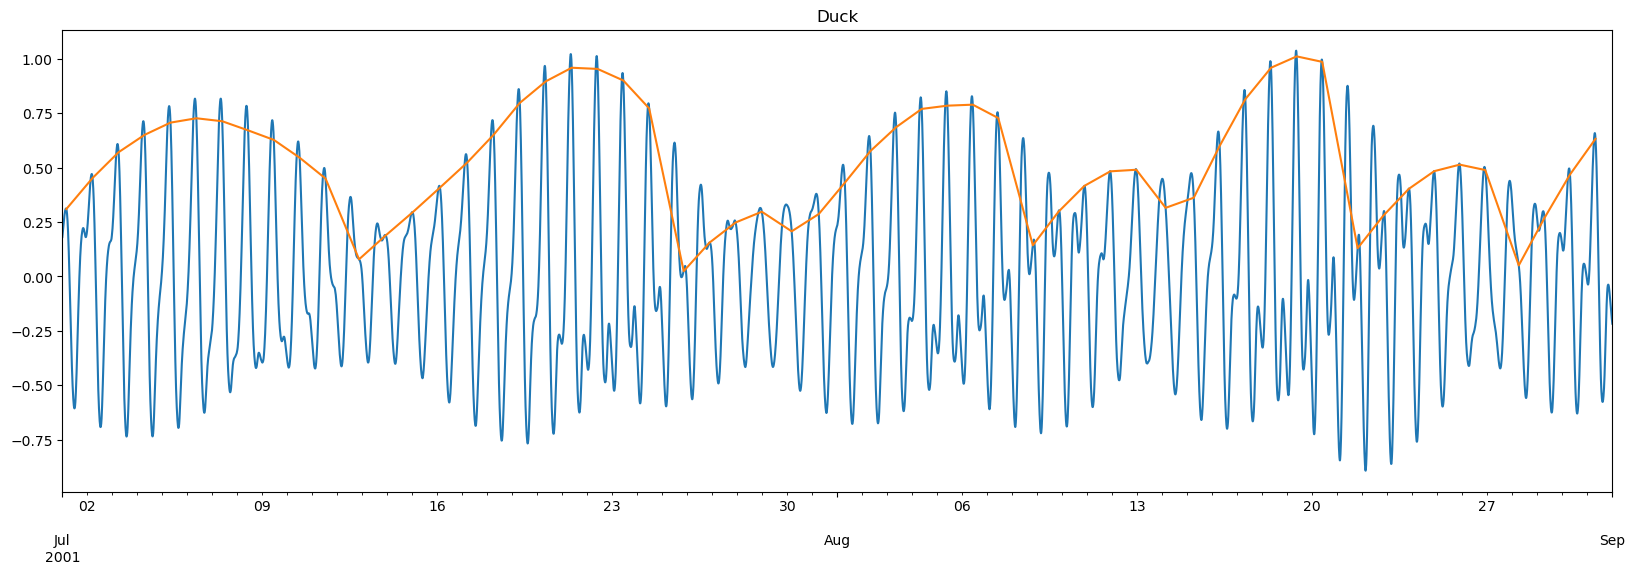

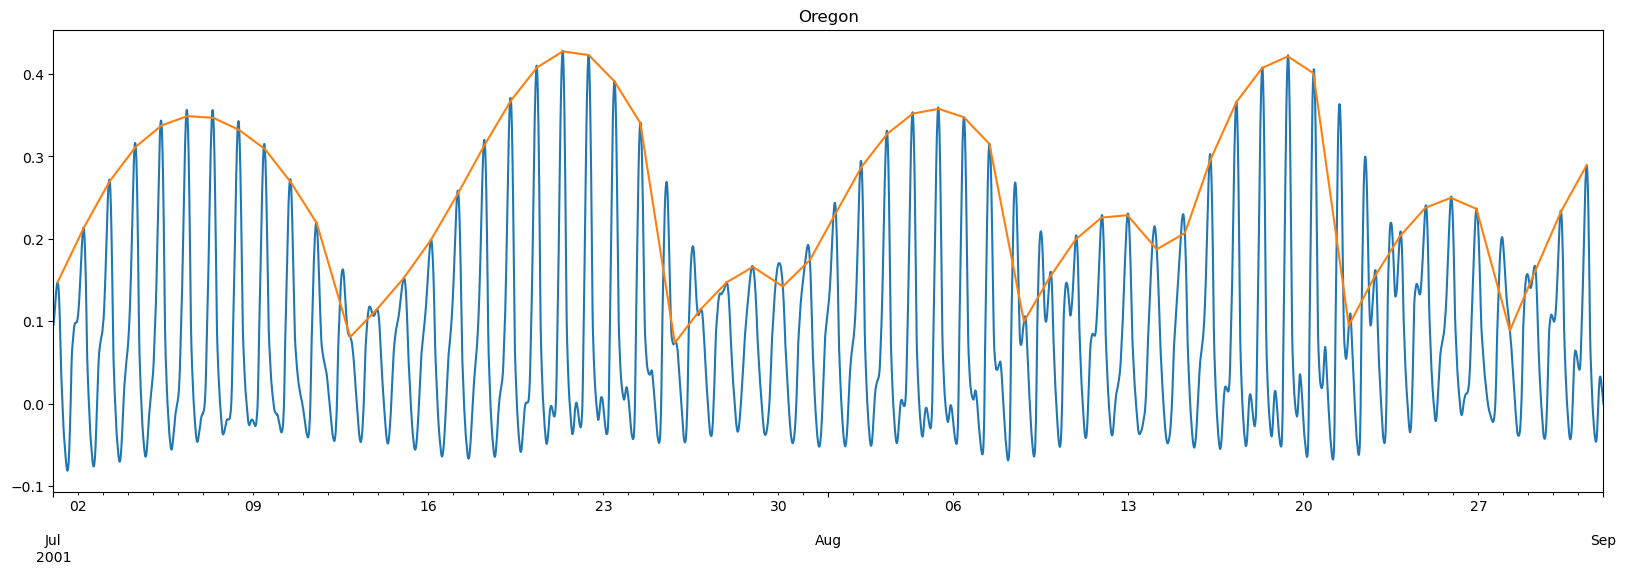

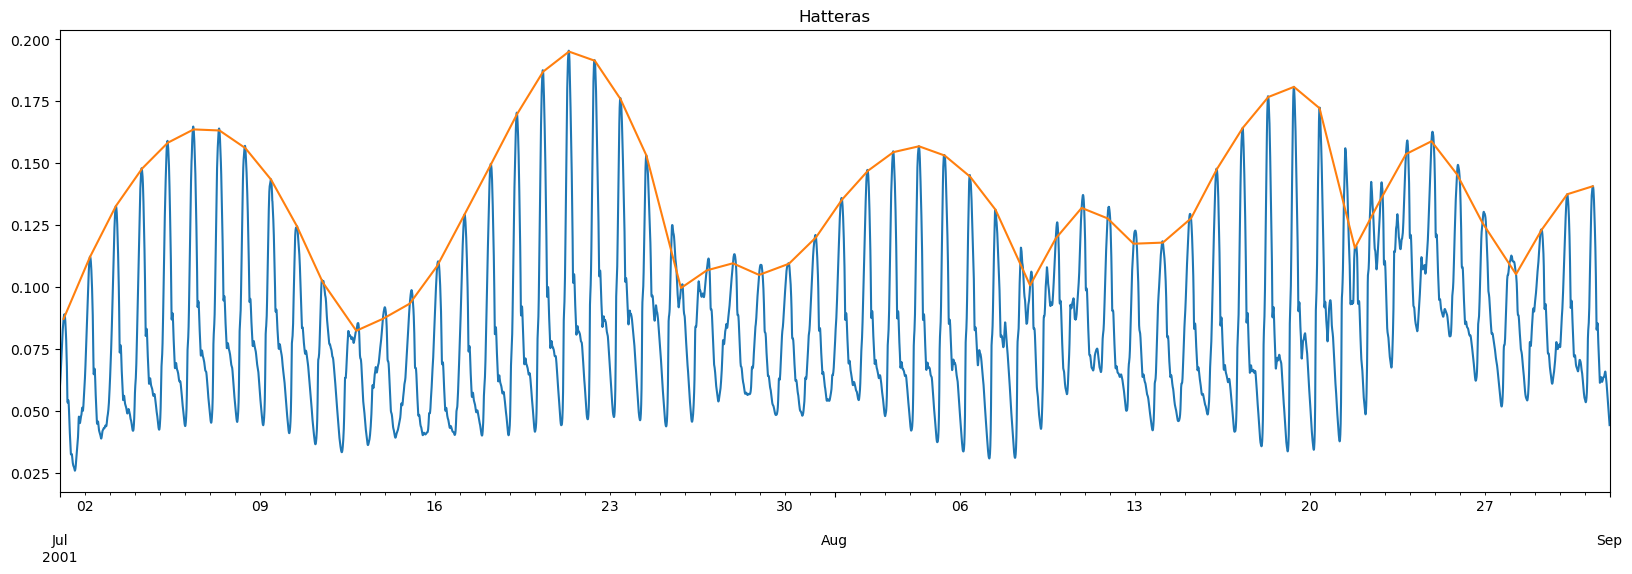

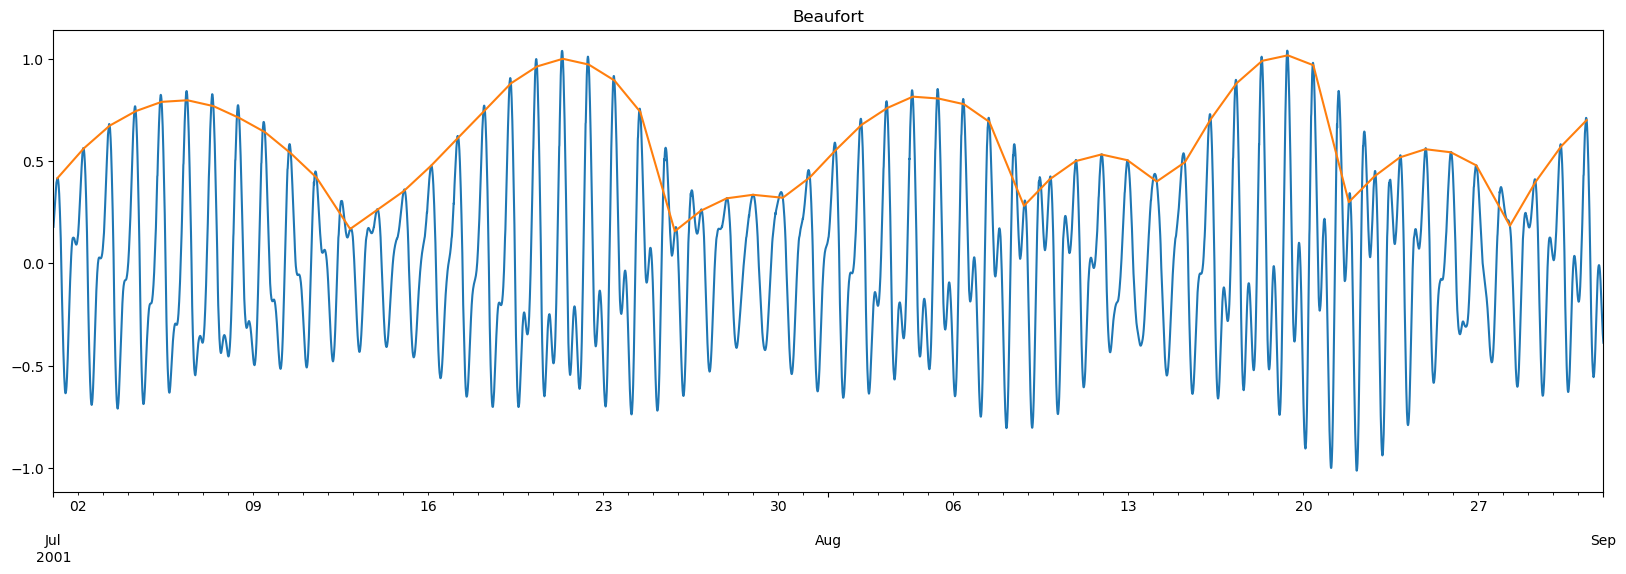

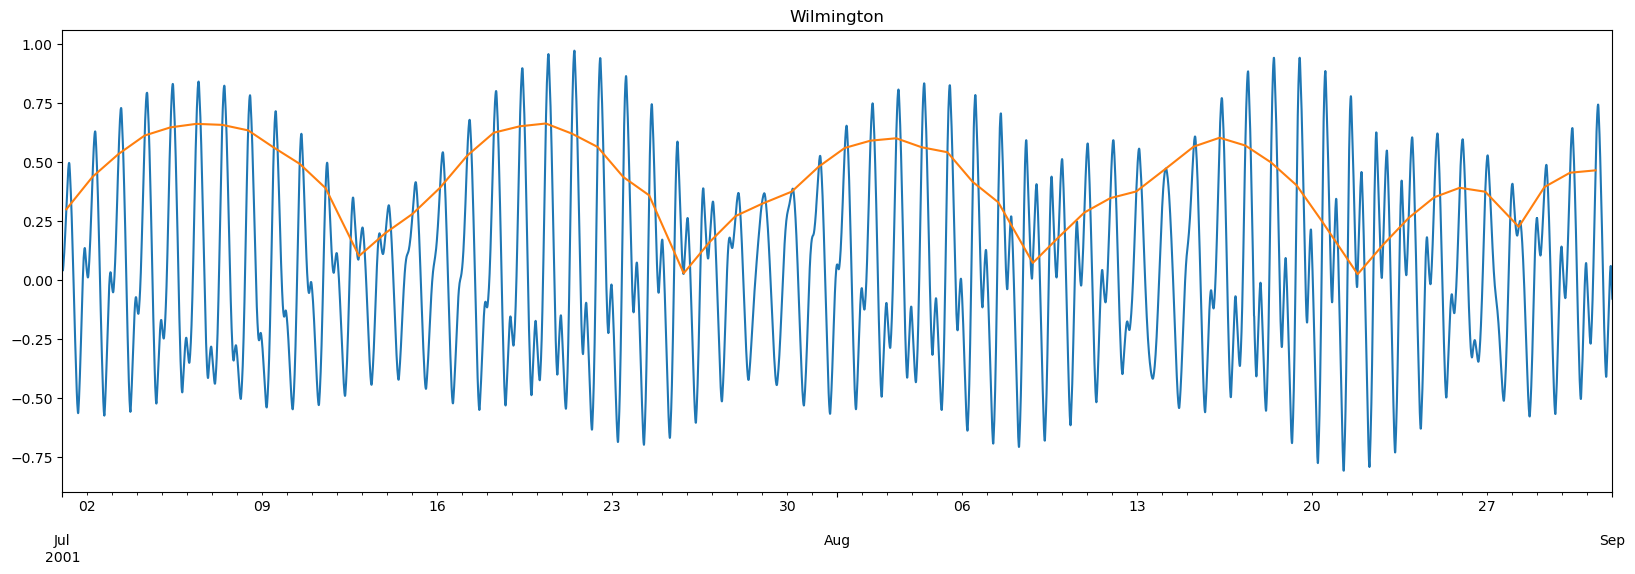

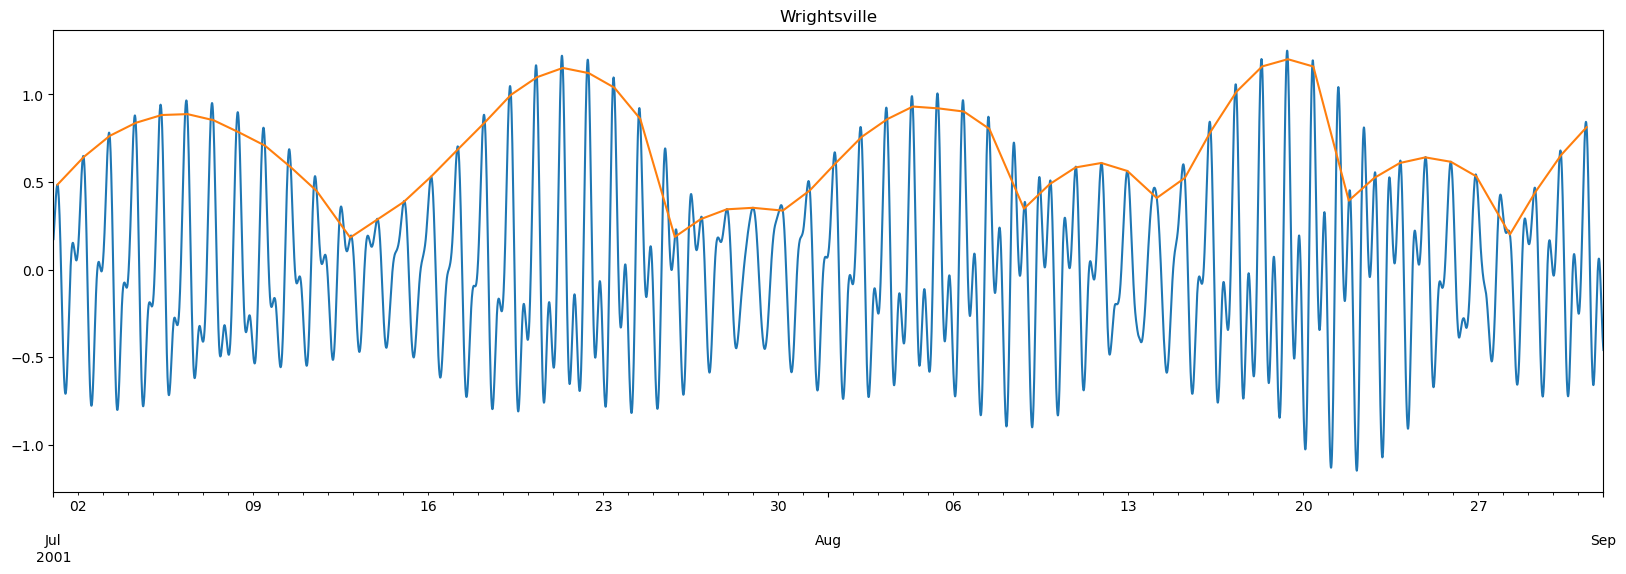

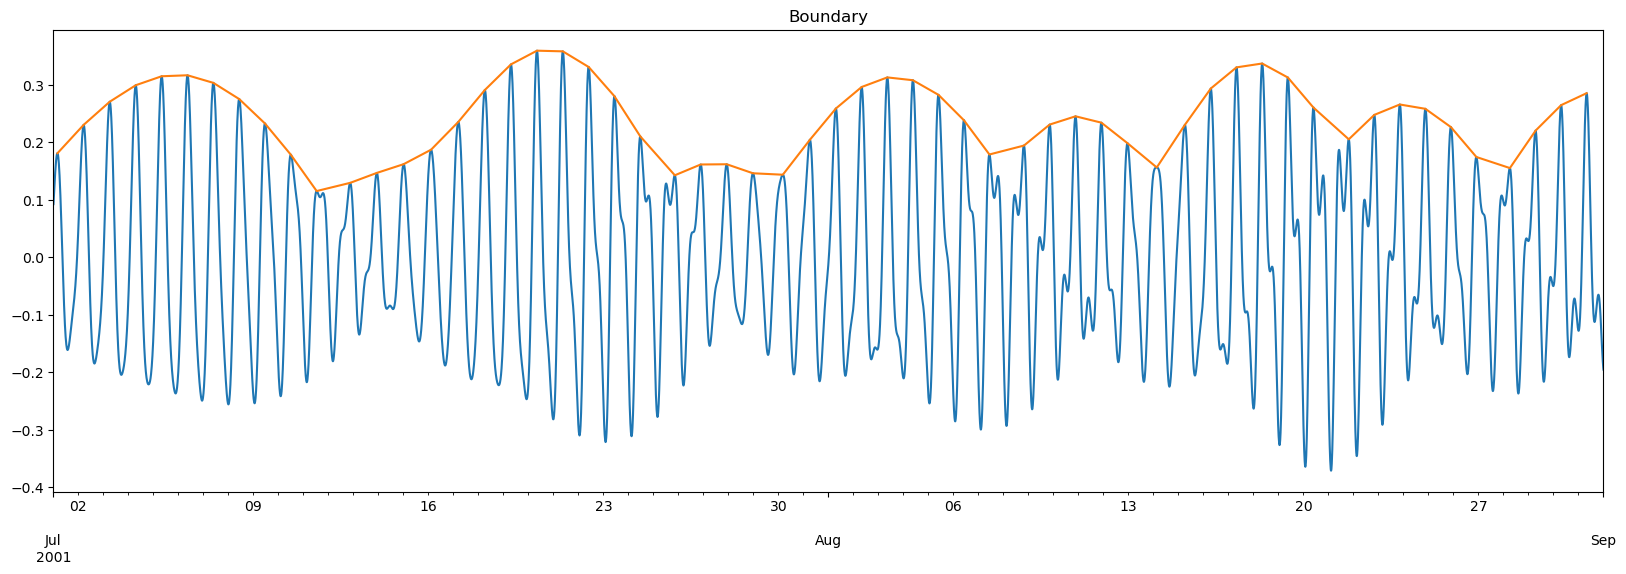

In [76]:
for icol, col in enumerate(baseNOAA.columns):
    fig, ax = plt.subplots(figsize = (20, 6))
    baseNOAAs[col].plot(ax = ax, color = ccolors[0])
    baseNOAAs.iloc[peaks, icol].plot(ax = ax, color = ccolors[1])
    ax.set_title(col)

In [77]:
len(dctPeaks['Duck'])

58

In [42]:
baseNOAA.iloc[peaks, icol]

2001-06-17 04:20:00    0.053717
2001-06-18 04:50:00    0.159167
2001-06-19 05:30:00    0.284595
2001-06-20 06:30:00    0.432325
2001-06-21 07:20:00    0.573014
                         ...   
2001-08-26 22:00:00    0.488430
2001-08-28 06:10:00    0.050789
2001-08-29 06:50:00    0.268379
2001-08-30 07:20:00    0.467725
2001-08-31 07:50:00    0.631891
Name: Duck, Length: 71, dtype: float64

In [43]:
peaks

array([  169,   316,   464,   614,   763,   913,  1063,  1214,  1365,
        1517,  1670,  1872,  2029,  2182,  2333,  2483,  2633,  2782,
        2931,  3080,  3229,  3377,  3526,  3675,  3868,  4021,  4176,
        4334,  4491,  4644,  4794,  4944,  5093,  5242,  5390,  5539,
        5738,  5887,  6037,  6188,  6360,  6516,  6666,  6814,  6962,
        7109,  7257,  7403,  7550,  7749,  7897,  8046,  8195,  8345,
        8514,  8676,  8825,  8973,  9121,  9269,  9416,  9620,  9767,
        9914, 10061, 10208, 10355, 10548, 10696, 10843, 10990])